# 1. Projet Optimisation et Apprentissage

# 2. Methodes Utilitaires

## 2.1. Affichage des graphiques

L'objectif de ce projet est d'implémenter les différents modèles de programmation linéaire en variables mixtes vus en cours pour les Support Vector Machine (SVM) pour la séparation de points en deux dimensions.

**Remarque :** Comme vu en cours, on utilisera la norme 1 dans la fonction objective pour les différents modèles.

## Attendu pour ce projet

1. Générer un dataset composé de 20 points 2D aléatoires. Chaque point aura un label parmi $\{-1,1\}$ de telle manière que :
      * chaque classe a le même nombre de points,
      * les points sont linéairement séparables. 
2. Implémenter le problème d'optimisation linéaire déterminant l'hyperplan optimal et donner l'équation de cet hyperplan.
3. Modifier le label de 5 points afin de rendre ce dataset non linéairement séparable.
4. Implémenter deux modèles vus en cours (selon les losses choisies : hinge, Ramp ou Hard margin) permettant d'obtenir les hyperplans optimaux. Donner les deux hyperplans obtenus.
5. Comparer et discuter les résultats obtenus par les différents modèles.

**Optionnel :** 
* Vous pouvez ajouter des figures (générées avec `mathplotlib` par exemple) pour illustrer les hyperplans obtenus.
* Vous pouvez évaluer l'impact de la variation de la pondération $C$ utilisée dans les losses.
* Vous pouvez tester sur un dataset plus important.

Le projet doit être un fichier notebook python contenant les modèles et les résultats. Des images/photos peuvent être insérées dans ce fichier. 
Ce dernier doit être envoyé par mail à **lacroix@lipn.fr** avant le **9 mars 2025**.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

def plot_data_and_details(title, X, labels, w, b, slacks, ax=None):
    """
    X       : np.array shape (n,2) les coordonnées des points
    labels  : np.array shape (n,)   étiquettes (+1 ou -1)
    w1, w2  : flottants, paramètres du séparateur
    b       : flottant, biais
    slacks  : liste ou tableau des epsilons_i (même ordre que X)
    ax      : objet matplotlib.axes pour l'animation (si fourni)

    Affiche :
      - Les points (rouge pour -1, bleu pour +1)
      - La frontière de décision w1*x + w2*y + b = 0 (vert)
      - Les marges w.x + b = ±1 (pointillées noires)
      - Les segments pour les slacks
    """

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    else:
        ax.clear()

    if w is not None:
        w1, w2 = w[0], w[1]
    else:
        w1, w2 = None, None

    # Affichage des points
    ax.scatter(X[labels == 1, 0], X[labels == 1, 1], c='blue', label="Classe (+1)")
    ax.scatter(X[labels == -1, 0], X[labels == -1, 1], c='red', label="Classe (-1)")

    # Définition du range des axes
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x_vals = np.linspace(x_min, x_max, 300)

    # Tracé de la frontière de décision si w1 et w2 sont définis
    if w1 is not None:
        if abs(w2) > 1e-8:
            y_decision = -(w1 * x_vals + b) / w2
            y_plus = -(w1 * x_vals + (b - 1)) / w2
            y_minus = -(w1 * x_vals + (b + 1)) / w2

            ax.plot(x_vals, y_decision, 'g-', label='Frontière de décision')
            ax.plot(x_vals, y_plus, 'k--', label='Marge +1')
            ax.plot(x_vals, y_minus, 'k--', label='Marge -1')
        else:
            if abs(w1) > 1e-8:
                x_decision = -b / w1
                x_plus = -(b - 1) / w1
                x_minus = -(b + 1) / w1

                ax.axvline(x=x_decision, color='g', label='Frontière de décision')
                ax.axvline(x=x_plus, color='k', linestyle='--', label='Marge +1')
                ax.axvline(x=x_minus, color='k', linestyle='--', label='Marge -1')

    # Ajout des slacks
    if slacks is not None:
        w = np.array([w1, w2], dtype=float)
        w_norm_squared = w1**2 + w2**2

        for i, (pt, lab, xi) in enumerate(zip(X, labels, slacks)):
            if xi > 1e-9:
                alpha = 1.0 if lab == 1 else -1.0
                w_dot_pt = w1 * pt[0] + w2 * pt[1]
                delta = (alpha - b - w_dot_pt) / w_norm_squared
                pt_star = pt + delta * w

                ax.plot([pt[0], pt_star[0]], [pt[1], pt_star[1]],
                        color='orange', linewidth=1.5, alpha=0.8, zorder=3)

    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

## 2.2 Génération des données de Test

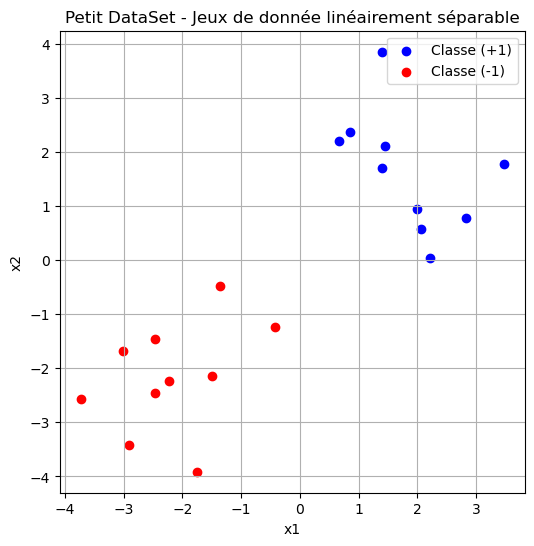

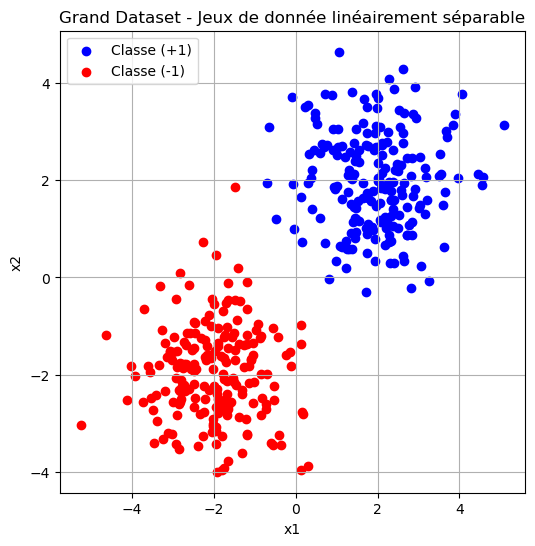

In [2]:
# Import necessary libraries
import numpy as np

# Generate dataset function
def generate_dataset(num_points_per_class, shift, num_labels_to_flip, seed=42):
    np.random.seed(seed)

    # Generate class points
    class_neg = np.random.randn(num_points_per_class, 2) - shift
    class_pos = np.random.randn(num_points_per_class, 2) + shift

    # Combine data
    X = np.vstack((class_neg, class_pos))
    y = np.array([-1]*num_points_per_class + [1]*num_points_per_class)

    # Flip labels randomly (introduce noise)
    flip_indices = np.random.choice(2*num_points_per_class, size=num_labels_to_flip, replace=False)
    y[flip_indices] *= -1

    return X, y
# Large dataset using specified parameters
X, y= generate_dataset(10, 2, 0)
plot_data_and_details("Petit DataSet - Jeux de donnée linéairement séparable", X, y , None, None, None) 

# Large dataset using specified parameters
X_large, y_large = generate_dataset(200, 2, 0)
plot_data_and_details("Grand Dataset - Jeux de donnée linéairement séparable", X_large, y_large , None, None, None)  

# 2. SVM à marge dure

Dans un SVM à marge dure, l'objectif est d'identifier un hyperplan qui sépare complètement les points de données appartenant à différentes classes, en garantissant une démarcation claire avec la plus grande largeur de marge possible. Cette marge est la distance entre l'hyperplan et le point de données le plus proche, également appelé vecteurs de support.

La fonction $\color{red}{\text{hardsvm model optimisation}}$ prends en entrées les données et les étiquettes associées. 

Welcome to the CBC MILP Solver 
Version: devel 
Build Date: Feb 11 2025
Starting solution of the Linear programming problem using Dual Simplex

Coin0506I Presolve 20 (-4) rows, 3 (-2) columns and 60 (-8) elements
Clp0000I Optimal - objective value 0.96849981
Coin0511I After Postsolve, objective 0.96849981, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 0.9684998121 - 3 iterations time 0.002, Presolve 0.00

Solution trouvée :
w1 = 0.5654675543017847, w2 = 0.5654675543017847, b = -0.26529493588390535
Equation de la droite séparatrice 0.5654675543017847 x1 + 0.40303225781959645 x2 + -0.26529493588390535 = 0
Starting solution of the Linear programming problem using Dual Simplex

Coin0506I Presolve 404 (0) rows, 5 (0) columns and 1208 (0) elements
Clp0000I Optimal - objective value 4.8819391
Clp0032I Optimal objective 4.881939083 - 7 iterations time 0.002

Solution trouvée :
w1 = 3.109826644033408, w2 = 3.109826644033408, b = 0.33469575032315013
Equation de la droite 

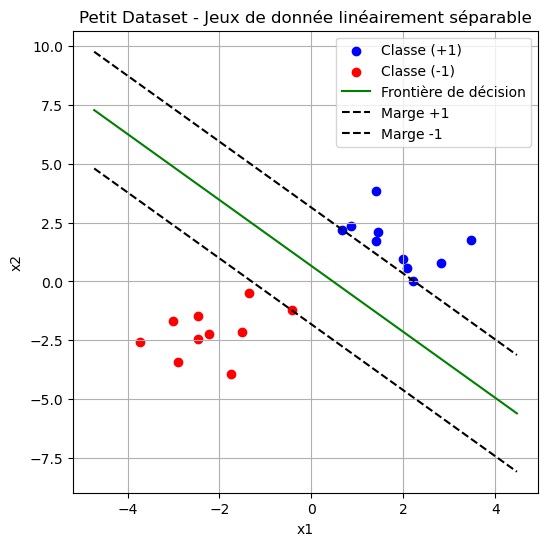

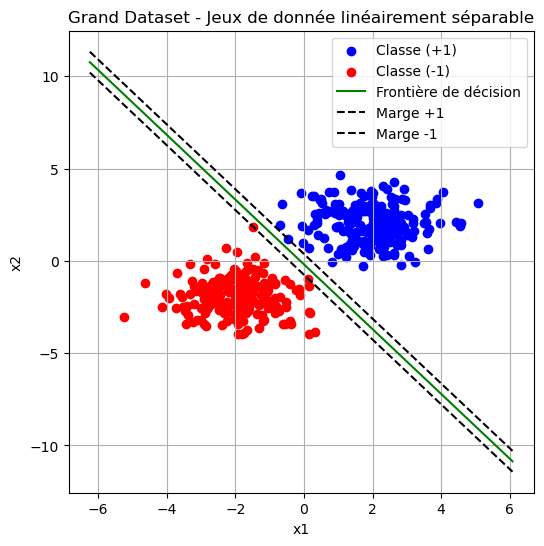

In [3]:
from mip import CONTINUOUS, MINIMIZE, Model, minimize, xsum

def hardsvm_model_optimisation(X, y):

    model = Model("Hard SVM Solver", sense=MINIMIZE)
    model.verbose = 1

    # n = nombre de points, d = nombre de dimensions
    n, d = len(X), len(X[0]) 

    # Variables de décision
    w = [model.add_var(name=f'w_{j}', var_type=CONTINUOUS, lb=float("-inf"), ub=float("inf")) for j in range(d)]     
    b = model.add_var(name="b", var_type=CONTINUOUS, lb=float("-inf"), ub=float("inf")) 
    
    # Variables auxiliaires pour la norme L1
    u = [model.add_var(name=f'u_{j}', var_type=CONTINUOUS) for j in range(d)]

    # Contraintes pour modéliser la norme L1 : u_i = |w_i|
    for j in range(d):
        model += u[j] >= w[j]
        model += u[j] >= -w[j]
    
    # Contraintes de séparation
    for i in range(n):
        model += y[i] * (xsum(w[j] * X[i][j] for j in range(d)) + b) >= 1 
    
    # Minimisation de la norme L1 de w
    model.objective = minimize(xsum(u[j] for j in range(d)))   
    model.optimize()    
    
    print(f"\nSolution trouvée :")
    print(f"w1 = {w[0].x}, w2 = {w[0].x}, b = {b.x}")

    print(f"Equation de la droite séparatrice {w[0].x} x1 + {w[1].x} x2 + {b.x} = 0")
    
    return [w_i.x for w_i in w], b.x

# Petit Dataset - Trouver la ligne de séparation optimale
w_hardsvm_opt, b_hardsvm_opt = hardsvm_model_optimisation(X, y)
title = "Hard-SVM (norme L1)"
plot_data_and_details("Petit Dataset - Jeux de donnée linéairement séparable", X, y, w_hardsvm_opt, b_hardsvm_opt , None)  

# Grand Dataset - Trouver la ligne de séparation optimale
w_hardsvm_opt, b_hardsvm_opt = hardsvm_model_optimisation(X_large, y_large)
title = "Hard-SVM (norme L1)"
plot_data_and_details("Grand Dataset - Jeux de donnée linéairement séparable", X_large, y_large, w_hardsvm_opt, b_hardsvm_opt , None)  

# 3. SVM à marge souple 

## 3.1 Modification de labels afin de rendre ce dataset non linéairement séparable

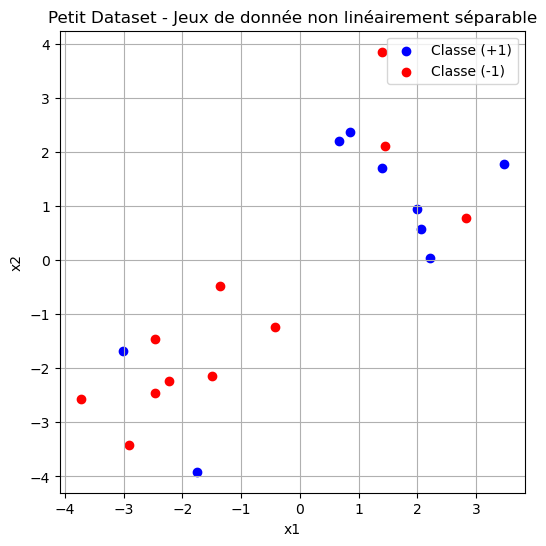

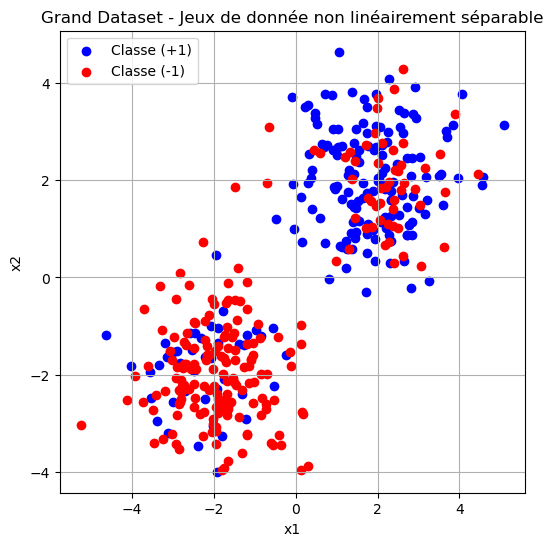

In [4]:
# Fixation la reproductibilité
np.random.seed(32)

def modification_label(y, percentage=0.25):
    y_flipped = y.copy()
    total_samples = len(y)
    num_flips = max(1, int(percentage * total_samples))  # Au moins 1 point modifié
    flip_indices = np.random.choice(total_samples, num_flips, replace=False)
    y_flipped[flip_indices] *= -1
    return y_flipped

y_flipped = modification_label(y)
plot_data_and_details("Petit Dataset - Jeux de donnée non linéairement séparable", X, y_flipped, None, None, None) 

y_large_flipped = modification_label(y_large)
plot_data_and_details("Grand Dataset - Jeux de donnée non linéairement séparable", X_large, y_large_flipped, None, None, None) 

## 3.2 Model 1 - Hinge Loss

### 3.2.1 Implémentation

La fonction $\color{red}{\text{svmsoft with hinge loss model optimisation}}$  est une tentative d'implémentation d'un SVM soft-margin avec une perte hinge en utilisant un modèle d'optimisation linéaire avec MIP (Mixed Integer Programming). Elle cherche à séparer des points en deux classes (+1 et -1) tout en autorisant quelques erreurs pour une meilleure généralisation.

Comme nous voulons la norme $L_1$ de ($w_1$, $w_2$), on introduirons deux variables auxiliaires ( $u_1$, $u_2$ ) pour forcer : $u_1$ = |$w_1$|,  $u_2$ = |$w_2$|.

<br><br>
Pour modéliser la fonction de perte $\color{red}{\text{Hinge Loss}}$, nous introduirons la contrainte suivantes:

Pour chaque point ($x_1^i$, $x_2^i$) et son label $y_i$, , on ajoute une variable d’erreur  $\epsilon_i$  (slack variable) qui permet de gérer les erreurs de classification :
$$
\begin{aligned}
    y_i (w^T x_i + b) &\geq 1 - \epsilon_i  && \forall i = 1, \dots, n \\
    \epsilon_i &\geq 0  && \forall i = 1, \dots, n
\end{aligned}
$$ 

Puis nous devrons minimiser:
$$
  \min \frac{1}{2} \|w\| + C \sum_{i=1}^{n} \epsilon_i
$$ 


In [5]:
from mip import Model, xsum, minimize, BINARY, CBC, CONTINUOUS

def svmsoft_with_hinge_loss_model_optimisation(X, y, C=1.0):
    """
    data   : liste des points (x1, x2)
    labels : liste des étiquettes correspondantes (+1 ou -1)
    C      : hyperparamètre pour pondérer la somme des slack variables
    """
    
    # Nombre d'échantillons et de caractéristiques
    n, d = len(X), len(X[0])  

    # Création du modèle
    model = Model("Soft SVM Solver", sense=minimize, solver_name=CBC)
    model.verbose = 0
    
        # Variables de décision
    w = [model.add_var(name=f'w_{i}', var_type=CONTINUOUS, lb=float("-inf"), ub=float("inf")) for i in range(d)]     
    b = model.add_var(name="b", var_type=CONTINUOUS, lb=float("-inf"), ub=float("inf"))
    epsilon = [model.add_var(name=f'epsilon_{j}', var_type=CONTINUOUS, lb=0) for j in range(n)] 

    # Variables auxiliaires pour la norme L1
    u = [model.add_var(name=f'u_{i}', var_type=CONTINUOUS) for i in range(d)]

    # Contraintes pour modéliser la norme L1 : u_i = |w_i|
    for i in range(d):
        model += u[i] >= w[i]
        model += u[i] >= -w[i]
    
    # Contraintes de séparation
    # Contraintes Hinge Loss
    for j in range(n):
        model += y[j] * (xsum(w[i] * X[j][i] for i in range(d)) + b) >= 1 - epsilon[j]  # Marge
        model += epsilon[j] >= 0  # Assurer que ξ ≥ 0
    
    # Fonction objectif : minimisation de la norme L1 + somme des erreurs Hinge Loss
    model.objective = (
        xsum(u[i] for i in range(d)) +  # Régularisation L1
        C * xsum(epsilon[j] for j in range(n))  # Perte Hinge
    )

    model.optimize()    
    
    print(f"\nSolution trouvée - Soft-SVM Hing Loss (norme L1) (C={C}):")
    print(f"w1 = {w[0].x}, w2 = {w[0].x}, b = {b.x}")

    print(f"Equation de la droite séparatrice {w[0].x} x1 + {w[1].x} x2 + {b.x} = 0")
    
    return C, [w_i.x for w_i in w], b.x, [epsilon_j.x for epsilon_j in epsilon]



Solution trouvée - Soft-SVM Hing Loss (norme L1) (C=100):
w1 = 0.39970075648167064, w2 = 0.39970075648167064, b = 0.11314150095907838
Equation de la droite séparatrice 0.39970075648167064 x1 + 0.09853859061832418 x2 + 0.11314150095907838 = 0


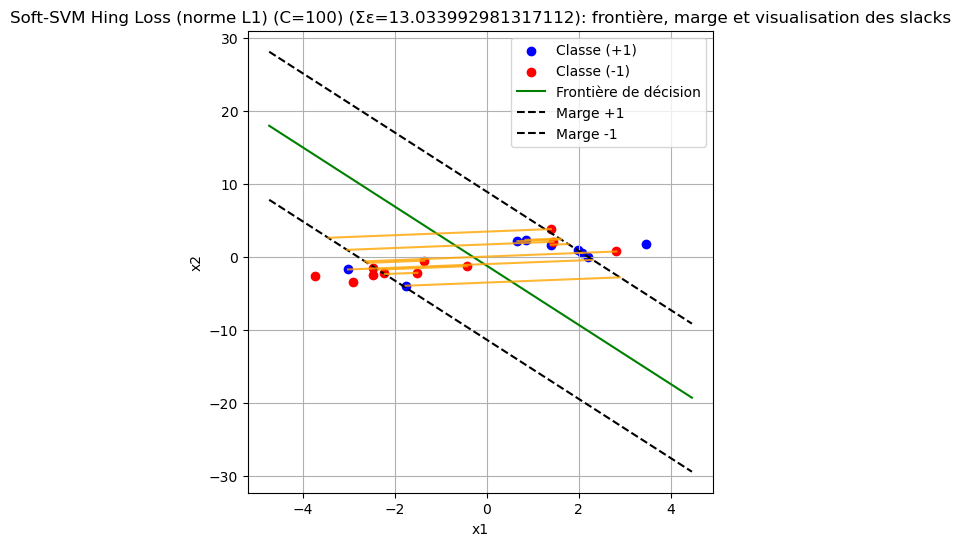

In [6]:
C, w, b, epsilons = svmsoft_with_hinge_loss_model_optimisation(X, y_flipped, C=100)
epsilon_sum = sum(epsilons)
title = f"Soft-SVM Hing Loss (norme L1) (C={C}) (Σε={epsilon_sum}): frontière, marge et visualisation des slacks"
plot_data_and_details(title, X, y_flipped, w, b, epsilons)   

### 3.2.2 Impcat de la constante C sur la marge avec Hinge Loss

Nous utliserons pour l'étude de l'impact de la constante C le grand dataset.


Solution trouvée - Soft-SVM Hing Loss (norme L1) (C=0.0001):
w1 = 0.0, w2 = 0.0, b = -1.0
Equation de la droite séparatrice 0.0 x1 + 0.0 x2 + -1.0 = 0

Solution trouvée - Soft-SVM Hing Loss (norme L1) (C=0.001):
w1 = 0.0, w2 = 0.0, b = -1.0
Equation de la droite séparatrice 0.0 x1 + 0.0 x2 + -1.0 = 0

Solution trouvée - Soft-SVM Hing Loss (norme L1) (C=0.01):
w1 = 0.1560885884358278, w2 = 0.1560885884358278, b = -0.025674870492362233
Equation de la droite séparatrice 0.1560885884358278 x1 + 0.28216133192610054 x2 + -0.025674870492362233 = 0

Solution trouvée - Soft-SVM Hing Loss (norme L1) (C=0.1):
w1 = 0.2118980707093248, w2 = 0.2118980707093248, b = -0.026065353616543493
Equation de la droite séparatrice 0.2118980707093248 x1 + 0.29294323493165536 x2 + -0.026065353616543493 = 0

Solution trouvée - Soft-SVM Hing Loss (norme L1) (C=1):
w1 = 0.20945737314729754, w2 = 0.20945737314729754, b = -0.03240380888559998
Equation de la droite séparatrice 0.20945737314729754 x1 + 0.2993254007675

/var/folders/ks/4y5sbqcj21lfbfdt9zrjwjfr0000gn/T/ipykernel_84632/490086801.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  delta = (alpha - b - w_dot_pt) / w_norm_squared
/var/folders/ks/4y5sbqcj21lfbfdt9zrjwjfr0000gn/T/ipykernel_84632/490086801.py:68: RuntimeWarning: invalid value encountered in multiply
  pt_star = pt + delta * w



Solution trouvée - Soft-SVM Hing Loss (norme L1) (C=10):
w1 = 0.20846528900972422, w2 = 0.20846528900972422, b = -0.03267122961156787
Equation de la droite séparatrice 0.20846528900972422 x1 + 0.30044853234403834 x2 + -0.03267122961156787 = 0

Solution trouvée - Soft-SVM Hing Loss (norme L1) (C=100):
w1 = 0.20846528900972422, w2 = 0.20846528900972422, b = -0.03267122961156787
Equation de la droite séparatrice 0.20846528900972422 x1 + 0.30044853234403834 x2 + -0.03267122961156787 = 0


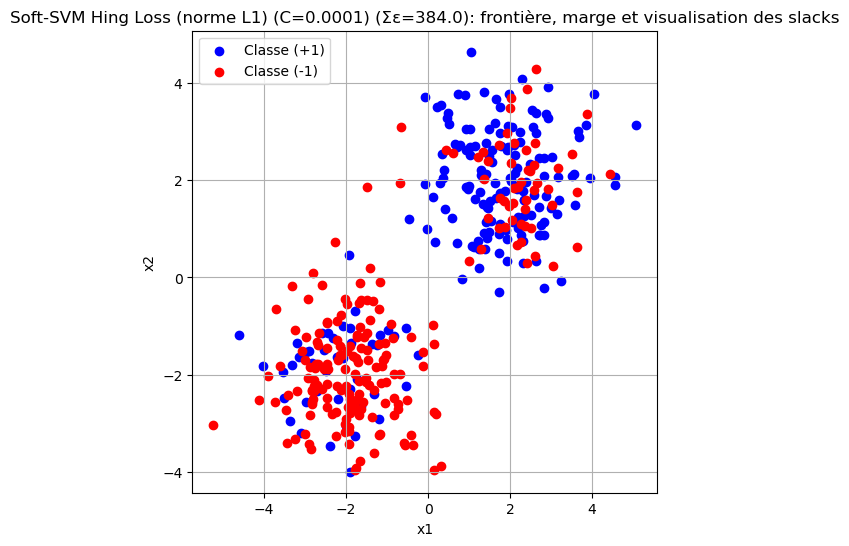

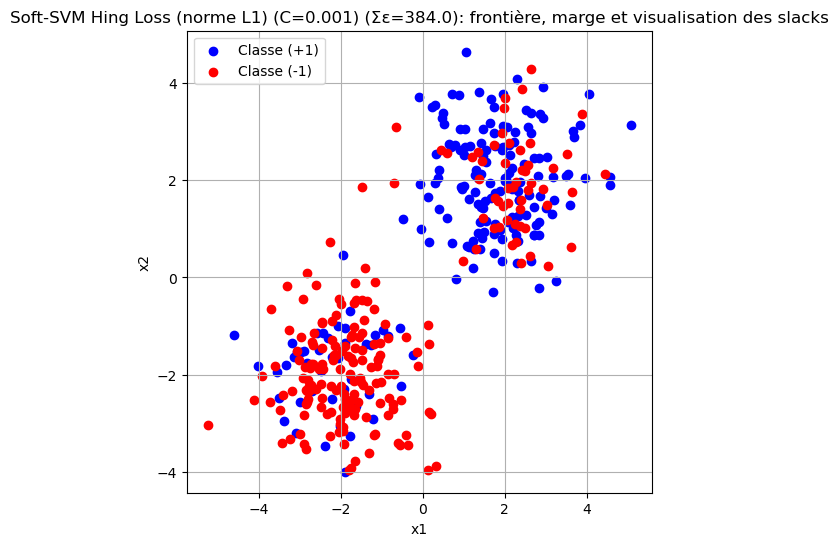

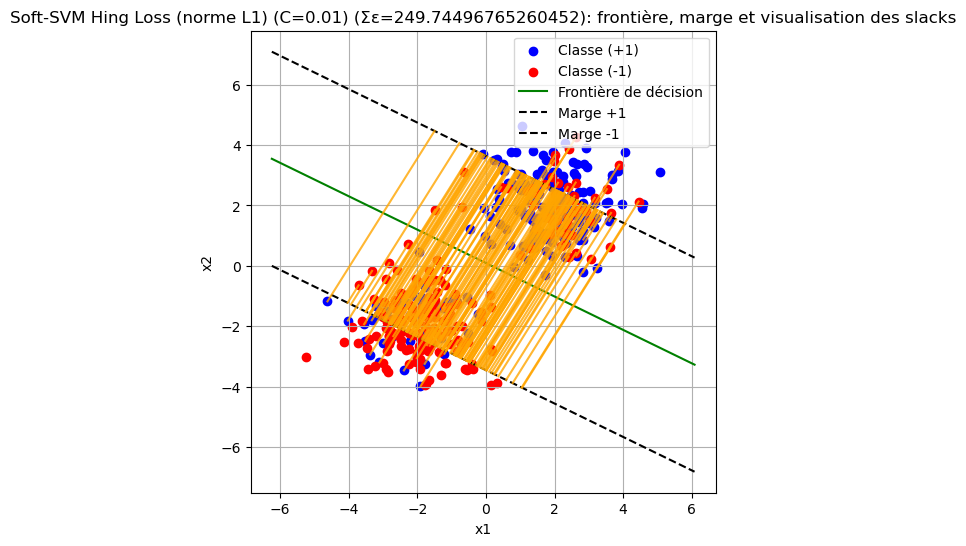

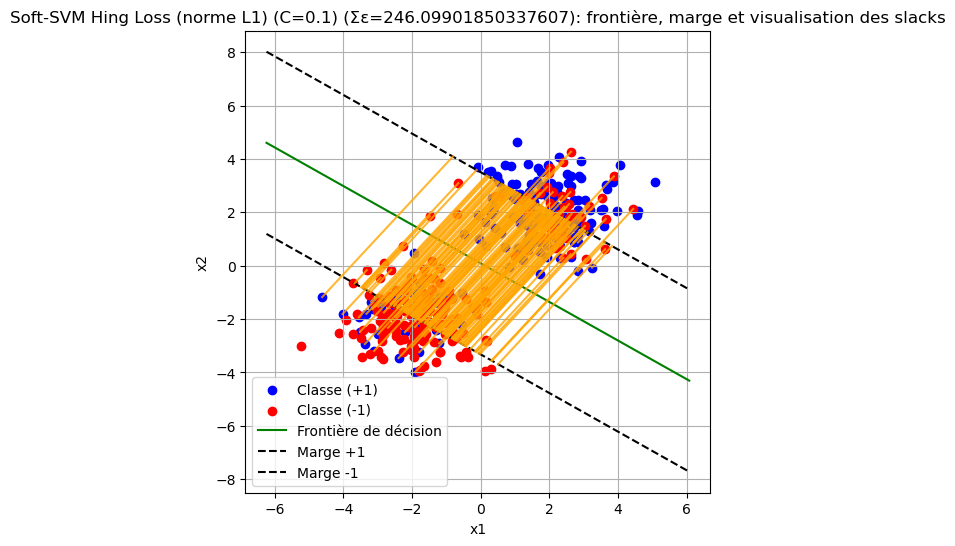

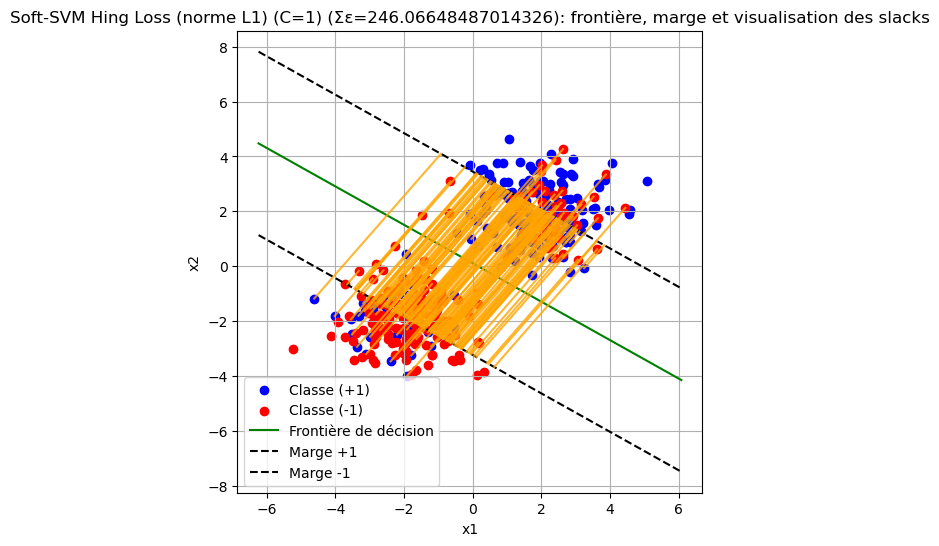

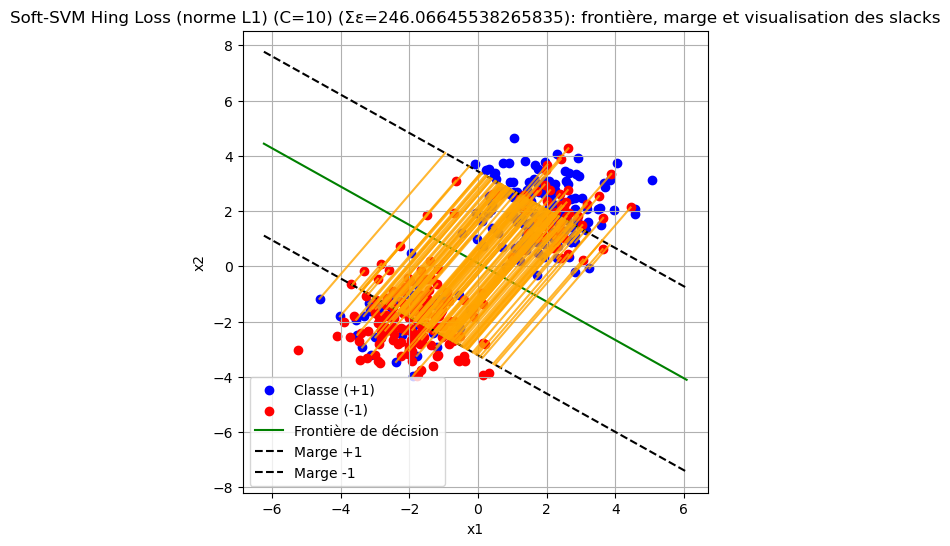

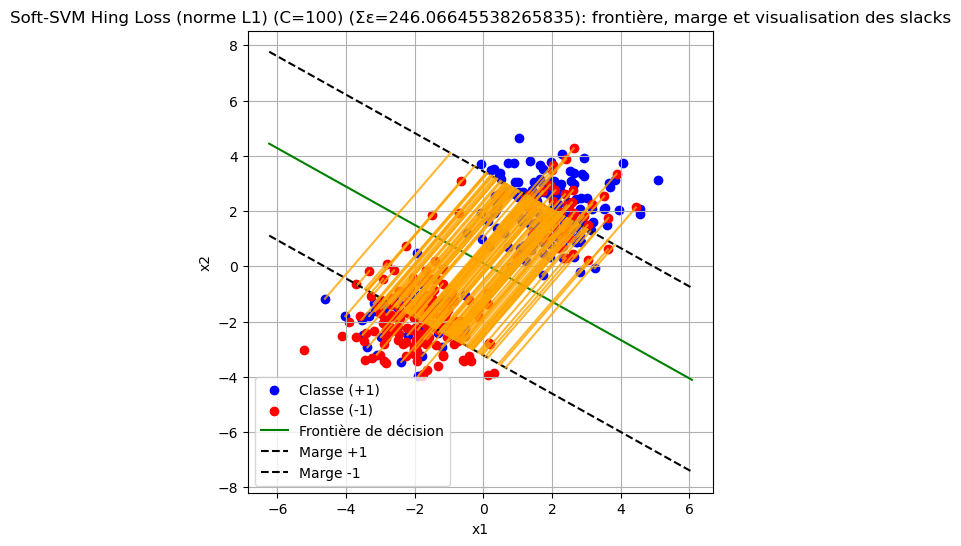

In [7]:
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
    
for c in C_values:
    c, w, b, epsilons = svmsoft_with_hinge_loss_model_optimisation(X_large, y_large_flipped, C=c)
    epsilon_sum = sum(epsilons)
    title = f"Soft-SVM Hing Loss (norme L1) (C={c}) (Σε={epsilon_sum}): frontière, marge et visualisation des slacks"
    plot_data_and_details(title, X_large, y_large_flipped, w, b, epsilons)   


A la lecture de résultats, nous pouvons remarquer que:

- Plus la constante C est grande, plus les erreurs sont sévèrement pénalisées, ce qui conduit le modèle à effectuer une séparation stricte des classes. La marge devient de plus en plus réduite à mesure que C augmente. À l’inverse, lorsque C est plus petit, le modèle tolère davantage d’erreurs, ce qui le rend plus permissif et entraîne une marge plus large.

- Dans le cas d’un dataset linéairement séparable, plus C est grand, plus la marge se réduit, jusqu’à ce que le modèle n’accepte plus aucune erreur de classification. En revanche, pour un dataset non linéairement séparable, certains points ne pourront jamais être parfaitement séparés, quelle que soit la valeur de C, aussi grande soit-elle.

## 3.3 Model 2 - Ramp Loss

### 3.3.1 Implémentation

Dans la suite de notre travail, nous etudierons une autre fonction de perte, la $\color{red}{\text{Ramp Loss}}$. La $\color{red}{\text{Ramp Loss}}$ est une version améliorée de la Hinge Loss qui limite la pénalisation des erreurs extrêmes. En effet elle est bornée et ne dépasse jamais 2 même pour les points très mal classés. Elle est donc moins sensible aux outliers ce qui veut dire qu'un point très éloigné ne contribue pas indéfiniment à la perte. 


<br><br>
Pour modéliser la fonction de perte $\color{red}{\text{Ramp Loss}}$, nous introduirons la contrainte suivantes:

Pour chaque point ($x_1^i$, $x_2^i$) et son label $y_i$, , on ajoute les variables d’erreur  $\epsilon_i$  (slack variable), M et $z_i$ qui permettent de gérer les erreurs de classification :
$$
\begin{aligned}
    y_i (w^T x_i + b) &\geq 1 - \epsilon_i - M z_i,  && \forall i = 1, \dots, n \\
    0 \leq \epsilon_i &\leq 2,  && \forall i = 1, \dots, n \\
    z_i &\in \{0,1\},  && \forall i = 1, \dots, n
\end{aligned}
$$ 

Puis nous devrons minimiser:
$$
  \min \frac{1}{2} \|w\| + C \left( \sum_{i=1}^{n} \epsilon_i + 2 \sum_{i=1}^{n} z_i \right)
$$



In [8]:
from mip import Model, xsum, minimize, BINARY, CONTINUOUS, CBC

def svmsoft_with_ramp_loss_model_optimisation(X, y, C=1.0, M=10):
    """
    Implémentation d'une SVM avec Ramp Loss en utilisant la programmation en nombres mixtes.

    Paramètres :
    - X : liste des points (x1, x2, ..., xd)
    - y : liste des étiquettes correspondantes (+1 ou -1)
    - C : hyperparamètre pour pondérer la somme des slack variables
    - M : grande constante pour l'activation des variables binaires (big-M)

    Retourne :
    - C : la valeur de l'hyperparamètre
    - w : vecteur des poids optimaux
    - b : biais optimal
    - epsilon : slack variables
    """
    
    # Nombre d'échantillons et de caractéristiques
    n, d = len(X), len(X[0])

    # Création du modèle
    model = Model("Soft SVM Ramp Loss Solver", sense=minimize, solver_name=CBC)
    model.verbose = 0
    
    # Variables de décision
    w = [model.add_var(name=f'w_{i}', var_type=CONTINUOUS, lb=float("-inf"), ub=float("inf")) for i in range(d)]
    b = model.add_var(name="b", var_type=CONTINUOUS, lb=float("-inf"), ub=float("inf"))
    epsilon = [model.add_var(name=f'epsilon_{j}', var_type=CONTINUOUS, lb=0, ub=2) for j in range(n)]  # Bornes de 0 à 2
    z = [model.add_var(name=f'z_{j}', var_type=BINARY) for j in range(n)]  # Variables binaires pour Ramp Loss

    # Variables auxiliaires pour la norme L1
    u = [model.add_var(name=f'u_{i}', var_type=CONTINUOUS) for i in range(d)]

    # Contraintes pour modéliser la norme L1 : u_i = |w_i|
    for i in range(d):
        model += u[i] >= w[i]
        model += u[i] >= -w[i]

    # Contraintes de séparation avec la Ramp Loss
    for j in range(n):
        model += y[j] * (xsum(w[i] * X[j][i] for i in range(d)) + b) >= 1 - epsilon[j] - M * z[j]  # Activation de z_j si erreur sévère
        model += epsilon[j] >= 0  # Assurer que ξ ≥ 0
        model += epsilon[j] <= 2  # Perte bornée à 2

    # Fonction objectif : minimisation de la norme L1 + somme des erreurs Ramp Loss
    model.objective = (
        xsum(u[i] for i in range(d)) +  # Régularisation L1
        C * xsum(epsilon[j] for j in range(n)) + 2 * xsum(z[j] for j in range(n))   # Ramp Loss (ε + 2z)
        #xsum(u[i] for i in range(d)) + C * xsum(epsilon[j] + 2 * z[j] for j in range(n))
    )

    model.optimize()

    print(f"\nSolution trouvée - Soft-SVM Ramp Loss (norme L1) (C={C}) (M={M}):")
    print(f"w = {[w_i.x for w_i in w]}, b = {b.x}")

    print(f"Equation de la droite séparatrice : {w[0].x} x1 + {w[1].x} x2 + {b.x} = 0")
    
    return C, M, [w_i.x for w_i in w], b.x, [epsilon_j.x for epsilon_j in epsilon], [z_j.x for z_j in z]


Solution trouvée - Soft-SVM Ramp Loss (norme L1) (C=100) (M=1000):
w = [0.5654675543017849, 0.4030322578195969], b = -0.2652949358839059
Equation de la droite séparatrice : 0.5654675543017849 x1 + 0.4030322578195969 x2 + -0.2652949358839059 = 0


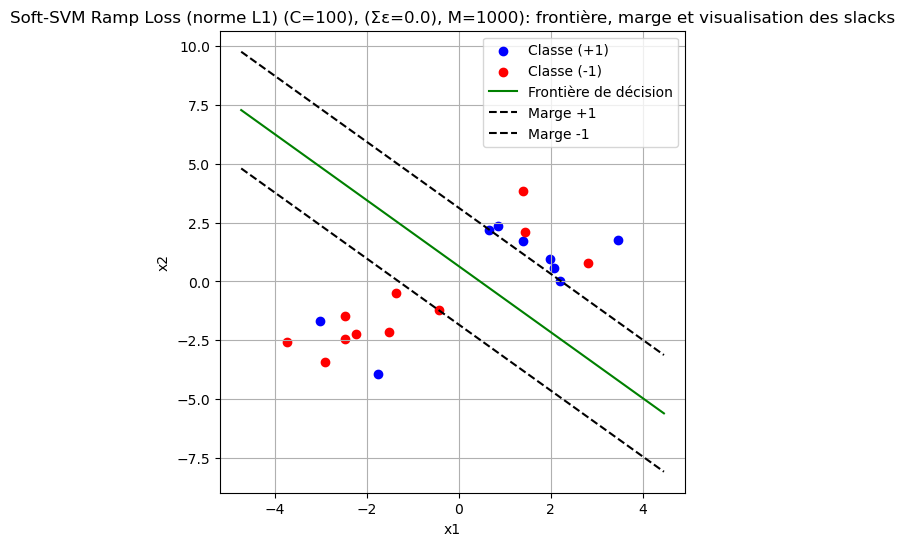

In [9]:
C, M, w, b, epsilons, zs = svmsoft_with_ramp_loss_model_optimisation(X, y_flipped, C=100, M=1000)
epsilon_sum = sum(epsilons)
title = f"Soft-SVM Ramp Loss (norme L1) (C={C}), (Σε={epsilon_sum}), M={M}): frontière, marge et visualisation des slacks"
plot_data_and_details(title, X, y_flipped, w, b, epsilons)   

### 3.3.2 Impcat de la constante C sur la marge avec Ramp Loss

Nous utliserons pour l'étude de l'impact de la constante C le grand dataset.


Solution trouvée - Soft-SVM Ramp Loss (norme L1) (C=100) (M=10000000):
w = [0.12641877808114538, 0.1706823380842311], b = -0.06176490867703528
Equation de la droite séparatrice : 0.12641877808114538 x1 + 0.1706823380842311 x2 + -0.06176490867703528 = 0

Solution trouvée - Soft-SVM Ramp Loss (norme L1) (C=100) (M=100000000):
w = [0.12641877808114538, 0.1706823380842311], b = -0.06176490867703528
Equation de la droite séparatrice : 0.12641877808114538 x1 + 0.1706823380842311 x2 + -0.06176490867703528 = 0


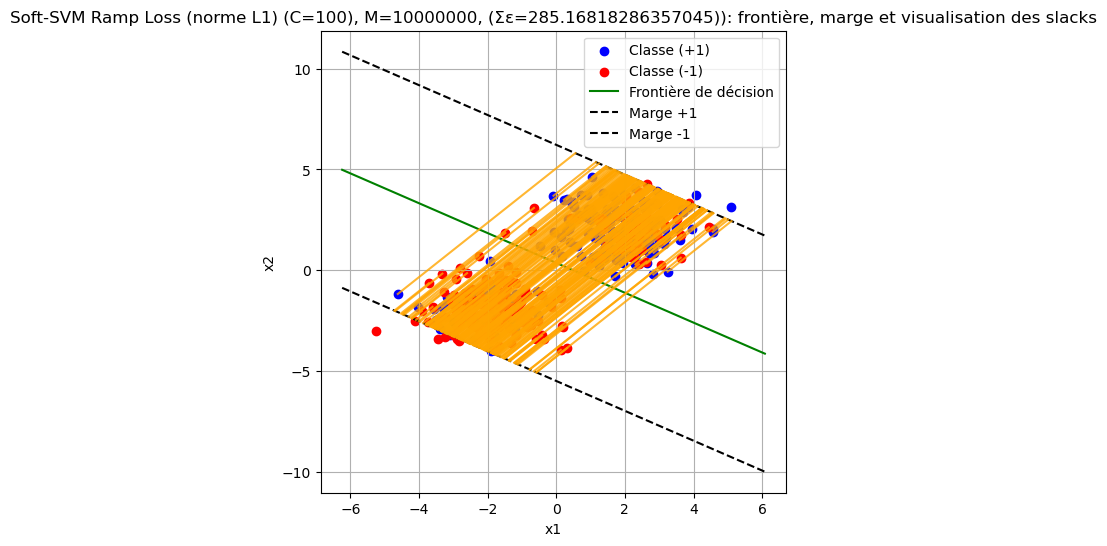

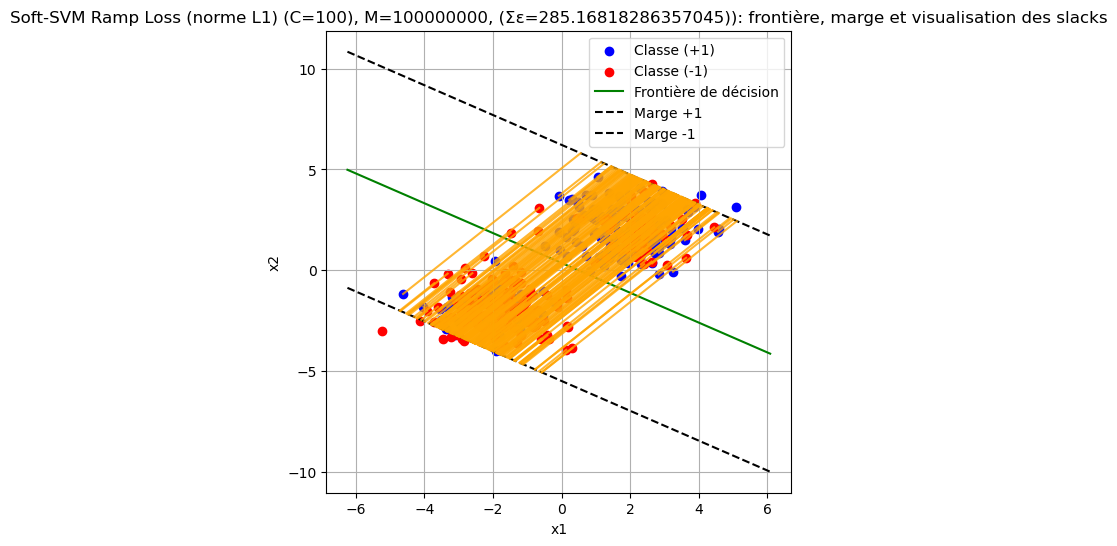

In [10]:
C_values = [100]
M_values = [10000000, 100000000]
for c in C_values:
    for m in M_values:
        C, M, w, b, epsilons, zs = svmsoft_with_ramp_loss_model_optimisation(X_large, y_large_flipped, C=c, M=m)
        epsilon_sum = sum(epsilons)
        title = f"Soft-SVM Ramp Loss (norme L1) (C={c}), M={m}, (Σε={epsilon_sum})): frontière, marge et visualisation des slacks"
        plot_data_and_details(title, X_large, y_large_flipped, w, b, epsilons)     

Les tests sur l'implémentation avec la Ramp loss montre que si la constante M choisi est trop petite ou pas assez grande alors les temps de calculs de l'agorithme explose de facons exponentiel. Nous tentons ci-dessous d'expliquer ce phénomène:

Si M est trop petit, le solveur MILP peine à distinguer les cas où $z_i$ = 0 ou $z_i$ = 1, ce qui l’oblige à explorer un grand nombre de configurations binaires, ralentissant considérablement l’optimisation. Un petit M complexifie aussi la relaxation continue, rendant l’élagage des branches inefficace. En revanche, un M suffisamment grand permet de fixer rapidement les valeurs de $z_i$, réduisant le nombre de branches explorées et accélérant la convergence. Toutefois, un M excessivement grand peut entraîner des instabilités numériques. 

## Conclusions

La Hinge Loss et la Ramp Loss sont deux fonctions de perte utilisées dans les SVM, mais elles diffèrent en termes de convexité, de robustesse et de complexité d’optimisation. 

La Hinge Loss est plutot utilisée dans les SVM classiques, est convexe et peut être optimisée efficacement à l’aide de solveurs linéaires. Elle pénalise proportionnellement les erreurs de classification, mais reste sensible aux outliers, car ceux-ci continuent d’augmenter la perte sans limitation. 

En revanche, la Ramp Loss est une variante plus robuste qui limite la pénalisation des erreurs extrêmes en bornant la perte maximale à 2. Cette approche réduit l’influence des outliers mais introduit une non-convexité dans le problème, nécessitant l’utilisation de la programmation en nombres mixtes (MILP) avec des variables binaires pour détecter les erreurs sévères. 

Contrairement à la Hinge Loss, qui se résout rapidement avec des algorithmes standards, la Ramp Loss exige des solveurs plus complexes. Ainsi, la Hinge Loss est préférable lorsque la rapidité est prioritaire et que les données sont relativement propres, tandis que la Ramp Loss est mieux adaptée aux datasets contenant des outliers, au prix d’une optimisation plus lourde.